In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, isnan, when, count, udf, year, month, to_date, mean, date_format
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import datetime
import pandas as pd 
spark = SparkSession.builder.getOrCreate()
print(spark)

23/05/29 20:02:32 WARN Utils: Your hostname, limelime.local resolves to a loopback address: 127.0.0.1; using 192.168.0.100 instead (on interface en0)
23/05/29 20:02:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/29 20:02:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
weather_df = spark.read.csv(path=f'data/london_weather.csv')

weather_df.printSchema()

weather_df= weather_df.drop("_c5")
weather_df.describe().show()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)



23/05/29 20:02:36 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+
|summary|                _c0|               _c1|              _c2|               _c3|               _c4|              _c6|               _c7|              _c8|                _c9|
+-------+-------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+
|  count|              15342|             15323|            15342|             15323|             15336|            15340|             15336|            15338|              13901|
|   mean|1.999567159344241E7| 5.268241743897663|4.350237924515966|118.75695078971414|15.388777306814523|7.559867005671808|1.6686338441474187|101536.6055943144|0.03798561151079137|
| stddev| 121217.55827681546|2.0700721035686156|4.028339404679589| 88.89827186362788| 6.554753578982

In [3]:
def func_reaname_columns(df, columns):
    if isinstance(columns, dict):
        return df.select(*[F.col(col_name).alias(columns.get(col_name, col_name)) for col_name in df.columns])
    else:
        raise ValueError("columns need to be in dict format{'name_a':'new_name_a', 'name_b':'new_name_b'}")
    
dict_columns = {"_c0":"date",
                "_c1":"cloud_cover",
                "_c2":"sunshine",
                "_c3":"global_radiation",
                "_c4":"max_temp",
                "_c6":"min_temp",
                "_c7":"precipitation",
                "_c8":"pressure",
                "_c9":"snow_depth",}
weather_df_renamed = func_reaname_columns(weather_df, dict_columns)





In [4]:
def format_date(date_string):
   
    date = pd.to_datetime(date_string, format="%Y%m%d")
    formatted_date = date.strftime("%Y-%m-%d")
    
    return formatted_date

weather_df_renamed = weather_df_renamed.withColumn("formatted_date", to_date(col("date"), "yyyyMMdd")).withColumn("formatted_date", date_format(col("formatted_date"), "yyyy-MM-dd")).drop("date").withColumnRenamed("formatted_date", "date")

weather_df_renamed.show()

+-----------+--------+----------------+--------+--------+-------------+--------+----------+----------+
|cloud_cover|sunshine|global_radiation|max_temp|min_temp|precipitation|pressure|snow_depth|      date|
+-----------+--------+----------------+--------+--------+-------------+--------+----------+----------+
|cloud_cover|sunshine|global_radiation|max_temp|min_temp|precipitation|pressure|snow_depth|      null|
|        2.0|     7.0|            52.0|     2.3|    -7.5|          0.4|101900.0|       9.0|1979-01-01|
|        6.0|     1.7|            27.0|     1.6|    -7.5|          0.0|102530.0|       8.0|1979-01-02|
|        5.0|     0.0|            13.0|     1.3|    -7.2|          0.0|102050.0|       4.0|1979-01-03|
|        8.0|     0.0|            13.0|    -0.3|    -6.5|          0.0|100840.0|       2.0|1979-01-04|
|        6.0|     2.0|            29.0|     5.6|    -1.4|          0.0|102250.0|       1.0|1979-01-05|
|        5.0|     3.8|            39.0|     8.3|    -6.6|          0.7|10

In [5]:
weather_df_renamed = weather_df_renamed.filter(col("date") != "0")

weather_df_renamed = weather_df_renamed.withColumn("avg_temp", (col("max_temp") + col("min_temp"))/2)


#avg = weather_df_renamed.filter(weather_df_renamed.avg_temp.isNotNull()).select(mean(col('min_temp')).alias('mean_min'), mean(col('max_temp')).alias('mean_max')).collect()

avg = weather_df_renamed.filter(weather_df_renamed.avg_temp.isNotNull())\
    .select(mean(col('min_temp')).alias('mean_min'), 
            mean(col('max_temp')).alias('mean_max')).collect()

mean_min = avg[0]['mean_min']
mean_max = avg[0]['mean_max']


weather_df_renamed = weather_df_renamed.na.fill(value=mean_min, subset=["min_temp"]).na.fill(value=mean_max, subset=["max_temp"]).na.fill(value=0, subset=["snow_depth"]) 



weather_df_renamed = weather_df_renamed.withColumn("max_temp", col("max_temp").cast("integer"))
weather_df_renamed = weather_df_renamed.withColumn("min_temp", col("min_temp").cast("integer"))
weather_df_renamed = weather_df_renamed.withColumn("precipitation", col("precipitation").cast("integer"))
weather_df_renamed = weather_df_renamed.withColumn("cloud_cover", col("cloud_cover").cast("integer"))
weather_df_renamed = weather_df_renamed.withColumn("sunshine", col("sunshine").cast("integer"))
weather_df_renamed = weather_df_renamed.withColumn("global_radiation", col("global_radiation").cast("integer"))
weather_df_renamed = weather_df_renamed.withColumn("pressure", col("pressure").cast("integer"))
weather_df_renamed = weather_df_renamed.withColumn("snow_depth", col("snow_depth").cast("integer"))


weather_df_renamed.printSchema()
weather_df_renamed.describe().show()


weather_df_renamed = weather_df_renamed.filter(weather_df_renamed["cloud_cover"].isNotNull())
weather_df_renamed = weather_df_renamed.filter(weather_df_renamed["sunshine"].isNotNull())
weather_df_renamed = weather_df_renamed.filter(weather_df_renamed["global_radiation"].isNotNull())

weather_df_renamed = weather_df_renamed.filter(weather_df_renamed["max_temp"].isNotNull())
weather_df_renamed = weather_df_renamed.filter(weather_df_renamed["min_temp"].isNotNull())
weather_df_renamed = weather_df_renamed.filter(weather_df_renamed["precipitation"].isNotNull())

weather_df_renamed = weather_df_renamed.filter(weather_df_renamed["pressure"].isNotNull())
weather_df_renamed = weather_df_renamed.filter(weather_df_renamed["snow_depth"].isNotNull())
weather_df_renamed = weather_df_renamed.filter(weather_df_renamed["date"].isNotNull())
weather_df_renamed = weather_df_renamed.filter(weather_df_renamed["avg_temp"].isNotNull())


weather_df_renamed.show()   

root
 |-- cloud_cover: integer (nullable = true)
 |-- sunshine: integer (nullable = true)
 |-- global_radiation: integer (nullable = true)
 |-- max_temp: integer (nullable = true)
 |-- min_temp: integer (nullable = true)
 |-- precipitation: integer (nullable = true)
 |-- pressure: integer (nullable = true)
 |-- snow_depth: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- avg_temp: double (nullable = true)

+-------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-------------------+----------+-----------------+
|summary|       cloud_cover|          sunshine|  global_radiation|         max_temp|         min_temp|     precipitation|         pressure|         snow_depth|      date|         avg_temp|
+-------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+-------------------+----------+-----------------+
|  co

In [6]:
def func_get_overview(df):
    print("FIRST RECORDS")
    print(df.limit(2).sort(col("date"), ascending=True).toPandas())

    print("COUNT NULL VALUES")
    print(df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c, y in df.dtypes if y in ["double", "float"]]).toPandas())

    # dublicates = df.groupby(weather_df_renamed.date).count(0).where('count > 1').limit(5).toPandas()
    # print(dublicates)

    print("PRINT SCHEMA")
    print(df.printSchema())

func_get_overview(weather_df_renamed)

FIRST RECORDS
   cloud_cover  sunshine  global_radiation  max_temp  min_temp  precipitation   
0            2         7                52         2        -7              0  \
1            6         1                27         1        -7              0   

   pressure  snow_depth        date  avg_temp  
0    101900           9  1979-01-01     -2.60  
1    102530           8  1979-01-02     -2.95  
COUNT NULL VALUES
   avg_temp
0         0
PRINT SCHEMA
root
 |-- cloud_cover: integer (nullable = true)
 |-- sunshine: integer (nullable = true)
 |-- global_radiation: integer (nullable = true)
 |-- max_temp: integer (nullable = true)
 |-- min_temp: integer (nullable = true)
 |-- precipitation: integer (nullable = true)
 |-- pressure: integer (nullable = true)
 |-- snow_depth: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- avg_temp: double (nullable = true)

None


In [7]:
def binner(min_temp, max_temp):
    if (min_temp is None) or (max_temp is None):
        return "unknown"
    else: 
        if min_temp < -10:
            return "frigid"
        elif min_temp < -5:
            return "very cold"
        elif min_temp < 0:
            return "cold"
        elif max_temp < 10:
            return "normal"
        elif max_temp < 20:
            return "warm"
        elif max_temp < 30:
            return "hot"
        elif max_temp >= 30:
            return "hotness"
    return "nornmal"

udf_temp = udf(binner, StringType())
weather_cleaned_df = weather_df_renamed.withColumn("temp_buckets", udf_temp(col("min_temp"), col("max_temp")))
weather_cleaned_df.limit(10).toPandas()


udf_binner_precipitation = udf(lambda x: "very rainy" if x > 50 else ("rainy" if x > 0 else "dry"), StringType())


weather_cleaned_df = weather_cleaned_df \
    .withColumn("precipitation_buckets", udf_binner_precipitation("precipitation")) \
    .withColumn("month", month(weather_cleaned_df.date)) \
    .withColumn("year", year(weather_cleaned_df.date)) 
weather_cleaned_df.limit(5).toPandas()


func_get_overview(weather_cleaned_df)


FIRST RECORDS
   cloud_cover  sunshine  global_radiation  max_temp  min_temp  precipitation   
0            2         7                52         2        -7              0  \
1            6         1                27         1        -7              0   

   pressure  snow_depth        date  avg_temp temp_buckets   
0    101900           9  1979-01-01     -2.60    very cold  \
1    102530           8  1979-01-02     -2.95    very cold   

  precipitation_buckets  month  year  
0                   dry      1  1979  
1                   dry      1  1979  
COUNT NULL VALUES
   avg_temp
0         0
PRINT SCHEMA
root
 |-- cloud_cover: integer (nullable = true)
 |-- sunshine: integer (nullable = true)
 |-- global_radiation: integer (nullable = true)
 |-- max_temp: integer (nullable = true)
 |-- min_temp: integer (nullable = true)
 |-- precipitation: integer (nullable = true)
 |-- pressure: integer (nullable = true)
 |-- snow_depth: integer (nullable = true)
 |-- date: string (nullable = tr

### Visualisation

23/05/29 20:02:49 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


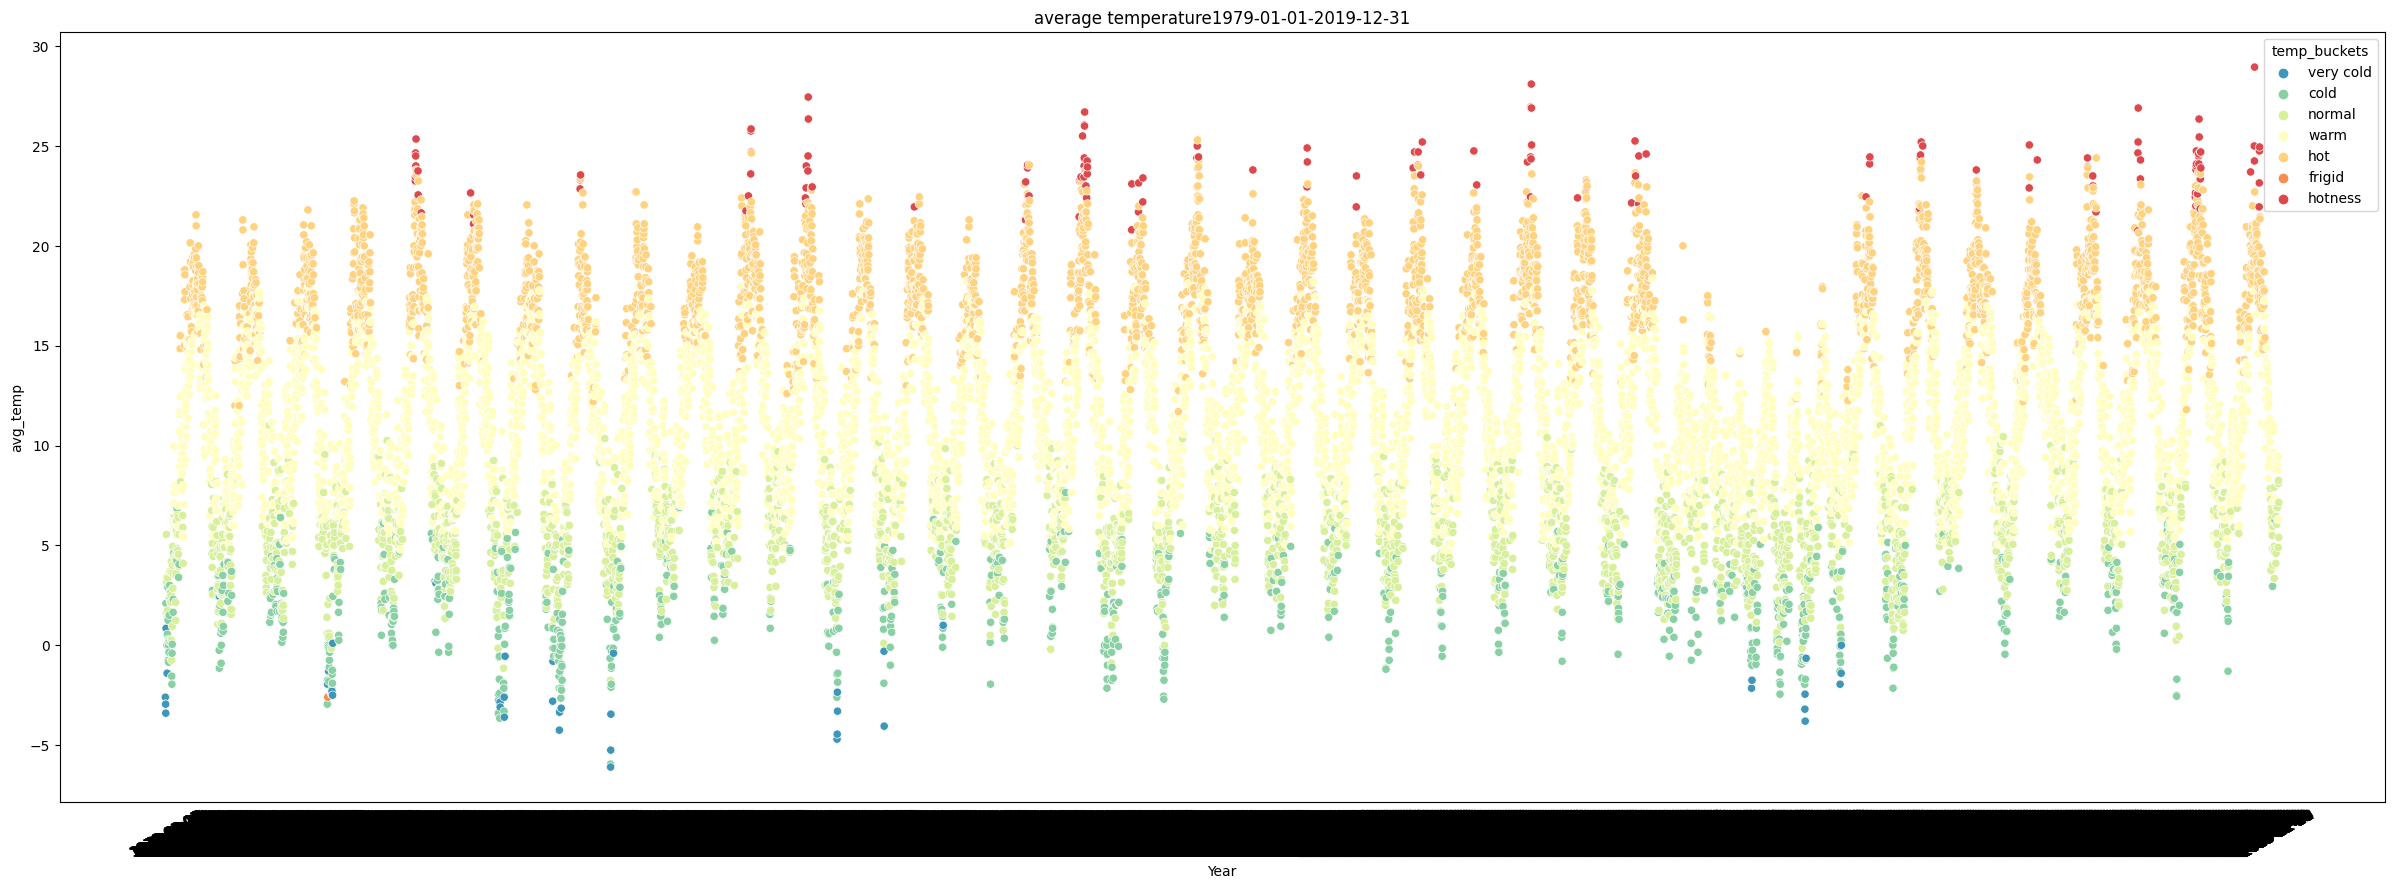

In [8]:


fig, ax = plt.subplots(figsize=(30,10))
sns.scatterplot(hue="temp_buckets", y="avg_temp", x="date", data=weather_cleaned_df.toPandas(), palette="Spectral_r")


ax.tick_params(axis="x", rotation=30, length=0)

mindate = str(weather_cleaned_df.agg({'date':'min'}).collect()[0]['min(date)'])
maxdate = str(weather_cleaned_df.agg({'date':'max'}).collect()[0]['max(date)'])
ax.set_title("average temperature: " + mindate + " - " + maxdate)
plt.xlabel("Year")
plt.show()